# Finetuning a multilingual SBERT model

In this notebook we will fintetune a sentence BERT model to output similar sentences from multiple languages in the same vector space. We will closely follow the paper [Making Monolingual Sentence Embeddings Multilingual using
Knowledge Distillation](https://arxiv.org/pdf/2004.09813.pdf) by Nils Reimers and Iryna Gurevych.

We will use knowledge distillation to train a student model to mimick a monolingual teacher model which has been finetuned to produce good sentence embeddings. As long as we have parallel data in source and target languague and a finetuned teacher model in either the source or target language, this technique can easily be used to extend the student models with relatively small amount of training data.

| ![](assets/multilingual_sbert.png) | 
|:--:| 
| Fig. 1. Illustration of Multilingual SBERT knowledge distillation. (Image source: https://www.sbert.net/examples/training/multilingual/README.html) |
<br>

In the above figure, the student model should map `Hello World` and the German translation `Hallo Welt` to the vector of teacher model(`Hello World`). Authors recommend using Mean Squared Error loss for finetuning.

Formally, for a `batch size B`, `teacher model M` and `student model Mhat` with parallel(translated) pairs of sentences `((s1, t1), (s2, t2), ... , (si, ti))` where `s` is the source language and `t` is the target language, the loss looks like

$$ \frac{1}{|B|} \sum_{j\in B} [(M(s_j) - \hat{M}(s_j))^2 + (M(s_j) - \hat{M}(t_j))^2] $$

It's recommended to use an English SBERT model as the teacher and XLMRoBERTa as the student model. We are using a cross lingual model as the student to take advantage of it's multilingual vocabulary. XLM-R has a vocab size of 250k from 100 different languages.

In [1]:
import random
from typing import Callable, Iterable

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
teacher_model_name = "sentence-transformers/paraphrase-distilroberta-base-v2"
student_model_name = "xlm-roberta-base"

In [3]:
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
student_tokenizer = AutoTokenizer.from_pretrained(student_model_name)

In [4]:
corpus = [
    "The roads on the highway were bad.",
    "My car broke down last night",
    "किसने कुत्तों को खुला छोड़ा",
    "Where are my dogs?",
    "Are the dogs outside?",
    "मेरी कार टूट गई",
    "मेरी कार हाईवे पर खराब हो गई",
    "I wonder if they have reached home",
    "मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं"
]

In [5]:
for text in corpus:
    print(teacher_tokenizer.tokenize(text))

['The', 'Ġroads', 'Ġon', 'Ġthe', 'Ġhighway', 'Ġwere', 'Ġbad', '.']
['My', 'Ġcar', 'Ġbroke', 'Ġdown', 'Ġlast', 'Ġnight']
['à¤', 'ķ', 'à¤', '¿', 'à¤', '¸', 'à¤', '¨', 'à¥', 'ĩ', 'Ġà¤', 'ķ', 'à¥', 'ģ', 'à¤', '¤', 'à¥', 'į', 'à¤', '¤', 'à¥', 'ĭ', 'à¤', 'Ĥ', 'Ġà¤', 'ķ', 'à¥', 'ĭ', 'Ġà¤', 'ĸ', 'à¥', 'ģ', 'à¤', '²', 'à¤¾', 'Ġà¤', 'Ľ', 'à¥', 'ĭ', 'à¤', '¡', 'à¤', '¼', 'à¤¾']
['Where', 'Ġare', 'Ġmy', 'Ġdogs', '?']
['Are', 'Ġthe', 'Ġdogs', 'Ġoutside', '?']
['à¤', '®', 'à¥', 'ĩ', 'à¤', '°', 'à¥', 'Ģ', 'Ġà¤', 'ķ', 'à¤¾', 'à¤', '°', 'Ġà¤', 'Ł', 'à¥', 'Ĥ', 'à¤', 'Ł', 'Ġà¤', 'Ĺ', 'à¤', 'Ī']
['à¤', '®', 'à¥', 'ĩ', 'à¤', '°', 'à¥', 'Ģ', 'Ġà¤', 'ķ', 'à¤¾', 'à¤', '°', 'Ġà¤', '¹', 'à¤¾', 'à¤', 'Ī', 'à¤', 'µ', 'à¥', 'ĩ', 'Ġà¤', 'ª', 'à¤', '°', 'Ġà¤', 'ĸ', 'à¤', '°', 'à¤¾', 'à¤', '¬', 'Ġà¤', '¹', 'à¥', 'ĭ', 'Ġà¤', 'Ĺ', 'à¤', 'Ī']
['I', 'Ġwonder', 'Ġif', 'Ġthey', 'Ġhave', 'Ġreached', 'Ġhome']
['à¤', '®', 'à¥', 'ģ', 'à¤', 'Ŀ', 'à¥', 'ĩ', 'Ġà¤', 'Ĩ', 'à¤', '¶', 'à¥', 'į', 'à¤', 'ļ', 'à¤', '°', 'à¥', 'į', 'à¤',

In [6]:
for text in corpus:
    print(student_tokenizer.tokenize(text))

['▁The', '▁road', 's', '▁on', '▁the', '▁high', 'way', '▁were', '▁bad', '.']
['▁My', '▁car', '▁bro', 'ke', '▁down', '▁last', '▁night']
['▁किस', 'ने', '▁कु', 'त्त', 'ों', '▁को', '▁खुला', '▁छोड़', 'ा']
['▁Where', '▁are', '▁my', '▁dog', 's', '?']
['▁Are', '▁the', '▁dog', 's', '▁outside', '?']
['▁मेरी', '▁कार', '▁टूट', '▁गई']
['▁मेरी', '▁कार', '▁हाई', 'वे', '▁पर', '▁खराब', '▁हो', '▁गई']
['▁I', '▁wonder', '▁if', '▁they', '▁have', '▁reached', '▁home']
['▁मुझे', '▁आश्चर्य', '▁है', '▁कि', '▁क्या', '▁वे', '▁घर', '▁पहुंच', '▁गए', '▁हैं']


We can clearly see that the teacher model with just the english vocabulary does a very bad job in tokenizing texts in hindi. The hindi text has been broken down into individual characters which is hardly useful for representation purposes.

The XLM-R model on the otherhand does a great job in tokenizing both the hindi and english texts. It's clear that common hindi tokens are present in it's vocab.

In [7]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data preparation

Note that we will be using relatively small dataset here as we need to fit two models in gpu memory hence limiting our batch size hence leading to much larger training times on a single GPU(3080 in my case).

In [8]:
def is_valid_len(d):
    d = d["translation"]
    return len(d["en"]) > 30 and len(d["en"]) < 64 and len(d["hi"]) > 20 and len(d["hi"]) < 64

In [9]:
dataset = datasets.load_dataset("cfilt/iitb-english-hindi", split="train")

dataset = dataset.filter(lambda x: True if is_valid_len(x) and (random.random() > 0.9) else False)

len(dataset), dataset[0]

Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Reusing dataset parquet (/home/utsav/.cache/huggingface/datasets/cfilt___parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)
Parameter 'function'=<function <lambda> at 0x7fe07aa828b0> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Loading cached processed dataset at /home/utsav/.cache/huggingface/datasets/cfilt___parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8

(133571,
 {'translation': {'en': 'The default plugin layout for the top panel',
   'hi': 'ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका'}})

In [10]:
%%time

teacher_tokenized_en = teacher_tokenizer([data["translation"]["en"] for data in dataset],
                                         max_length=64, padding="max_length",
                                         truncation=True, verbose=True)

student_tokenized_en = student_tokenizer([data["translation"]["en"] for data in dataset],
                                         max_length=64, padding="max_length",
                                         truncation=True, verbose=True)

student_tokenized_hi = student_tokenizer([data["translation"]["hi"] for data in dataset],
                                         max_length=64, padding="max_length",
                                         truncation=True, verbose=True)

CPU times: user 1min 1s, sys: 8.05 s, total: 1min 9s
Wall time: 32.7 s


Now we will create out custom dataset and dataloaders with train/validation split for training.

In [11]:
class EnHiDataset:
    def __init__(
        self, teacher_en_tokens: dict, student_en_tokens: dict, student_hi_tokens: dict
    ):
        self.teacher_en_tokens = teacher_en_tokens
        self.student_en_tokens = student_en_tokens
        self.student_hi_tokens = student_hi_tokens

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {
            "teacher_en_input_ids": torch.tensor(
                self.teacher_en_tokens["input_ids"][ix], dtype=torch.long
            ),
            "teacher_en_attention_mask": torch.tensor(
                self.teacher_en_tokens["attention_mask"][ix], dtype=torch.long
            ),
            "student_en_input_ids": torch.tensor(
                self.student_en_tokens["input_ids"][ix], dtype=torch.long
            ),
            "student_en_attention_mask": torch.tensor(
                self.student_en_tokens["attention_mask"][ix], dtype=torch.long
            ),
            "student_hi_input_ids": torch.tensor(
                self.student_hi_tokens["input_ids"][ix], dtype=torch.long
            ),
            "student_hi_attention_mask": torch.tensor(
                self.student_hi_tokens["attention_mask"][ix], dtype=torch.long
            )
        }

    def __len__(self) -> int:
        return len(self.teacher_en_tokens["input_ids"])

In [12]:
%%time

dataset = EnHiDataset(teacher_tokenized_en, student_tokenized_en, student_tokenized_hi)

CPU times: user 1.52 ms, sys: 4.25 ms, total: 5.77 ms
Wall time: 5.76 ms


In [13]:
len(dataset)

133571

In [14]:
train_ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Model config

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

The method `mean_pool()` implements the mean token pooling strategy mentioned in the paper. The implementation has been picked up from the `sentente_transformers` library.

In [16]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool

In [17]:
teacher_model = AutoModel.from_pretrained(teacher_model_name).to(device)
student_model = AutoModel.from_pretrained(student_model_name).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.Adam(student_model.parameters(), lr=2e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

## Training loop

In [19]:
def get_train_step_fn(
    teacher_model: torch.nn.Module, student_model: torch.nn.Module,
    optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler.LambdaLR,
    loss_fn: torch.nn.CrossEntropyLoss
) -> Callable:

    def train_step_fn(d: torch.tensor) -> float:
        student_model.train()

        teacher_model_out = teacher_model(
            d["teacher_en_input_ids"].to(device), d["teacher_en_attention_mask"].to(device)
        )
        teacher_en_pooled = mean_pool(
            teacher_model_out.last_hidden_state, d["teacher_en_attention_mask"].to(device)
        )

        student_en_model_out = student_model(
            d["student_en_input_ids"].to(device), d["student_en_attention_mask"].to(device)
        )
        student_hi_model_out = student_model(
            d["student_hi_input_ids"].to(device), d["student_hi_attention_mask"].to(device)
        )
        student_en_pooled = mean_pool(
            student_en_model_out.last_hidden_state, d["student_en_attention_mask"].to(device)
        )
        student_hi_pooled = mean_pool(
            student_hi_model_out.last_hidden_state, d["student_hi_attention_mask"].to(device)
        )
        
        loss = (loss_fn(student_en_pooled, teacher_en_pooled) +
                loss_fn(student_hi_pooled, teacher_en_pooled)) / 2

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(
    teacher_model: torch.nn.Module, student_model: torch.nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss
) -> Callable:

    def val_step_fn(d: torch.tensor) -> float:
        student_model.eval()

        teacher_model_out = teacher_model(
            d["teacher_en_input_ids"].to(device), d["teacher_en_attention_mask"].to(device)
        )
        teacher_en_pooled = mean_pool(
            teacher_model_out.last_hidden_state, d["teacher_en_attention_mask"].to(device)
        )

        student_en_model_out = student_model(
            d["student_en_input_ids"].to(device), d["student_en_attention_mask"].to(device)
        )
        student_hi_model_out = student_model(
            d["student_hi_input_ids"].to(device), d["student_hi_attention_mask"].to(device)
        )
        student_en_pooled = mean_pool(
            student_en_model_out.last_hidden_state, d["student_en_attention_mask"].to(device)
        )
        student_hi_pooled = mean_pool(
            student_hi_model_out.last_hidden_state, d["student_hi_attention_mask"].to(device)
        )
        
        loss = (loss_fn(student_en_pooled, teacher_en_pooled) +
                loss_fn(student_hi_pooled, teacher_en_pooled)) / 2

        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader, step_fn: Callable[torch.tensor, torch.tensor], is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data)
        mini_batch_losses.append(loss)
        if i % (batch_size * 1000) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

In [20]:
%%time

n_epochs = 1

train_step_fn = get_train_step_fn(teacher_model, student_model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(teacher_model, student_model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Training ...
step     0/53428, loss =  0.683
step  2000/53428, loss =  0.303
step  4000/53428, loss =  0.331
step  6000/53428, loss =  0.281
step  8000/53428, loss =  0.258
step 10000/53428, loss =  0.246
step 12000/53428, loss =  0.259
step 14000/53428, loss =  0.235
step 16000/53428, loss =  0.327
step 18000/53428, loss =  0.180
step 20000/53428, loss =  0.129
step 22000/53428, loss =  0.144
step 24000/53428, loss =  0.167
step 26000/53428, loss =  0.209
step 28000/53428, loss =  0.140
step 30000/53428, loss =  0.187
step 32000/53428, loss =  0.167
step 34000/53428, loss =  0.173
step 36000/53428, loss =  0.149
step 38000/53428, loss =  0.176
step 40000/53428, loss =  0.189
step 42000/53428, loss =  0.170
step 44000/53428, loss =  0.240
step 46000/53428, loss =  0.191
step 48000/53428, loss =  0.201
step 50000/53428, loss =  0.157
step 52000/53428, loss =  0.116

Validating ...
step     0/13358, loss =  0.200
step  2000/13358, loss =  0.198
step  4000/13358, loss =  0.241
step  6000

In [22]:
train_losses, val_losses

([0.19776925913485568], [0.15786257060084322])

In [23]:
student_model.save_pretrained("models/student_multi_enhi")

Normally we look at losses over multiple epochs, but here we have only 1 epoch. One way to look at the mini batch losses is to use a running mean(smoothing) to reduce noise from per batch loss.

In [24]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

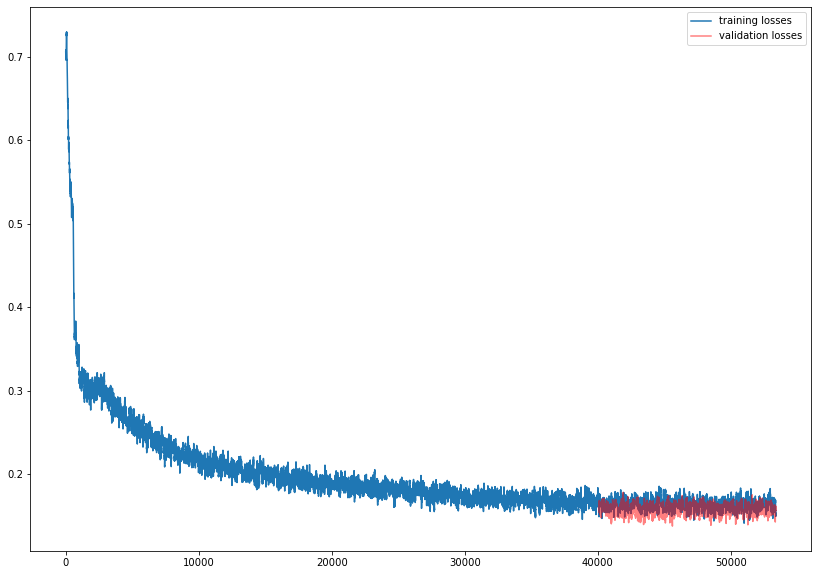

In [41]:
fix, ax = plt.subplots(figsize=(14, 10))
n_train_losses = len(train_mb_running_loss)
ax.plot(range(n_train_losses), train_mb_running_loss, label="training losses");
ax.plot(range(n_train_losses-len(val_mb_running_loss), n_train_losses),
        val_mb_running_loss, c="r", alpha=0.5, label="validation losses")
ax.legend();

## Evaluation 

In [26]:
def get_ranked_docs(
    tokenizer: AutoTokenizer, model: AutoModel, device: str, query: str, corpus: list[str]
) -> None:
    
    query_embed = mean_pool(model(**tokenizer(query, return_tensors="pt").to(device)).last_hidden_state,
                            tokenizer(query, return_tensors="pt")["attention_mask"].to(device))

    corpus_last_hidden_state = model(
        **tokenizer(corpus, max_length=64, padding=True, truncation=True, return_tensors="pt").to(device)
    ).last_hidden_state

    corpus_embeds = mean_pool(
        corpus_last_hidden_state,
        tokenizer(corpus, max_length=64, padding=True,truncation=True, return_tensors="pt")["attention_mask"].to(device)
    )

    scores = torch.nn.CosineSimilarity()(query_embed, corpus_embeds)
    
    print(f"Query - {query}\n---")
    scores = scores.cpu().detach().numpy()
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

We will load the original student model again to compare it's performance with the finetuned model.

In [27]:
original_student_model = AutoModel.from_pretrained(student_model_name)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
query = "Who let the dogs out"

corpus = [
    "A frog jumped in the pond",
    "My car broke down last night",
    "किसने कुत्तों को खुला छोड़ा",
    "Where are my dogs?",
    "Are the dogs outside?",
    "मेरी कार टूट गई",
    "I wonder if they have reached home",
    "मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं"
]

In [29]:
get_ranked_docs(student_tokenizer, student_model, "cuda", query, corpus)

Query - Who let the dogs out
---
0.84	किसने कुत्तों को खुला छोड़ा
0.67	Are the dogs outside?
0.63	Where are my dogs?
0.40	A frog jumped in the pond
0.39	मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं
0.38	I wonder if they have reached home
0.17	मेरी कार टूट गई
0.13	My car broke down last night


In [30]:
get_ranked_docs(student_tokenizer, original_student_model, "cpu", query, corpus)

Query - Who let the dogs out
---
1.00	Are the dogs outside?
1.00	I wonder if they have reached home
1.00	A frog jumped in the pond
1.00	Where are my dogs?
1.00	My car broke down last night
1.00	मेरी कार टूट गई
1.00	किसने कुत्तों को खुला छोड़ा
0.99	मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं


In [31]:
query = "My car broke down on the highway"

corpus = [
    "The roads on the highway were bad.",
    "My car broke down last night",
    "किसने कुत्तों को खुला छोड़ा",
    "Where are my dogs?",
    "Are the dogs outside?",
    "मेरी कार टूट गई",
    "मेरी कार हाईवे पर खराब हो गई",
    "I wonder if they have reached home",
    "मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं"
]

In [32]:
get_ranked_docs(student_tokenizer, student_model, "cuda", query, corpus)

Query - My car broke down on the highway
---
0.94	मेरी कार हाईवे पर खराब हो गई
0.93	My car broke down last night
0.93	मेरी कार टूट गई
0.68	The roads on the highway were bad.
0.14	I wonder if they have reached home
0.12	Where are my dogs?
0.08	मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं
0.06	Are the dogs outside?
0.06	किसने कुत्तों को खुला छोड़ा


In [33]:
get_ranked_docs(student_tokenizer, original_student_model, "cpu", query, corpus)

Query - My car broke down on the highway
---
1.00	The roads on the highway were bad.
1.00	My car broke down last night
1.00	मेरी कार हाईवे पर खराब हो गई
1.00	मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं
1.00	I wonder if they have reached home
1.00	Are the dogs outside?
0.99	किसने कुत्तों को खुला छोड़ा
0.99	Where are my dogs?
0.99	मेरी कार टूट गई


Our finetuned model is doing a great job in retrieving the most relevant documents from the corpus, both in english and hindi. The bert-base model is scoring all the documents exactly the same. Here are the hi-en translations for those who don't have access to internet.

- किसने कुत्तों को खुला छोड़ा - Who let the dogs out
- मेरी कार हाईवे पर खराब हो गई - My car broke down on the highway
- मेरी कार टूट गई - My car broke down
- मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं - I wonder if they've reached home

I could not find any STS datset between en-hi to evaluate this model effectively. 

---

## References

[1] Nils Reimers and Iryna Gurevych. "[Making Monolingual Sentence Embeddings Multilingual using Knowledge Distillation](https://arxiv.org/pdf/2004.09813.pdf)"

[2] https://www.sbert.net